# Homework 6

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

### Due Date: 2025-05-06

* Matheus Raka Pradnyatama
* matheusraka@uchicago.edu

This homework relies on multiple files (from previous weeks):

- the bond symbology file `bond_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the bond market data file `bond_market_prices_eod`,
- the SOFR OIS Swap symbology file `sofr_swap_symbology`,
- the SOFR OIS Swap market data file `sofr_swaps_market_data_eod`.

-----------------------------------------------------------
# Parametric Credit Models: 
# Nelson-Siegel credit model for smooth hazard rate curves

### This homework  implements some of the concepts introduced in Lecture 6, "Parametric Hazard Rate Models"

### Follow the "Smooth parametric yield and hazard rate curves: the Nelson-Siegel model" in the "Smooth Credit Models" notebook
### You can also take a look at Dr. Mark Hendricks Fixed Income notebooks describing the Nelson-Siegel model calibration on US Treasuries.
-----------------------------------------------------------

In [46]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import QuantLib as ql
import datetime as dt
from scipy.optimize import fsolve
from scipy.optimize import root_scalar
from scipy.optimize import minimize

# The code is made with the help of OpenAI's ChatGPT.

# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

# Calculation/valuation date as pd datetime
as_of_date = pd.to_datetime('2024-12-13')

In [47]:
# nelson_siegel curve shape: Nelson-Siegel
def nelson_siegel(params, maturity):
    ''' params = (theta1, theta2, theta3, lambda)'''    
    
    if(maturity > 0):
        slope_1 = (1 - np.exp(-maturity/params[3]))/(maturity/params[3])
    else:            
        slope_1 = 1

    curvature_1 = slope_1 - np.exp(-maturity/params[3])

    total_value = params[0] + params[1] * slope_1 + params[2] * curvature_1
    
    return total_value

# nelson_siegel_extended curve shape: Nelson-Siegel-Svensson
def nelson_siegel_extended(params, maturity):

    if(maturity > 0):
        slope_1 = (1 - np.exp(-maturity/params[3]))/(maturity/params[3])
    else:            
        slope_1 = 1

    curvature_1 = slope_1 - np.exp(-maturity/params[3])

    total_value = params[0] + params[1] * slope_1 + params[2] * curvature_1    
    
    if(params[5] != 0):
        if(maturity > 0):
            slope_2 = (1 - np.exp(-maturity/params[5]))/(maturity/params[5])
        else:
            slope_2 = 1

        curvature_2 = slope_2 - np.exp(-maturity/params[5])

        total_value = total_value + params[4] * curvature_2
        
    
    return total_value


-----------------------------------------------------------
# Problem 1: Market Data preparation

## a. Prepare the VZ bond market data as of 2024-12-13
Load the symbology + market data dataframes and create a combined dataframe for all Verizon (ticker = 'VZ') fixed rate (cpn_type == 'FIXED') bonds with an outstanding amount greater than $100 MM (amt_out > 100).

Sort the dataframe by bond maturity and display the head of the dataframe.

Plot the VZ yields (Y-axis) by TTM (X-axis).

,date,isin,ticker,cpn_type,amt_out,maturity,midPrice,midYield,term,TTM
452,2024-12-13,US92343VGG32,VZ,FIXED,838.579,2026-03-20,96.2510,4.5405,4.993840,1.264887
428,2024-12-13,US92343VDD38,VZ,FIXED,984.778,2026-08-15,97.1630,4.4105,10.036961,1.670089
433,2024-12-13,US92343VDY74,VZ,FIXED,2938.298,2027-03-16,98.9935,4.5980,9.998631,2.253251
441,2024-12-13,US92343VFF67,VZ,FIXED,597.057,2027-03-22,96.5850,4.6020,7.003422,2.269678
453,2024-12-13,US92343VGH15,VZ,FIXED,2164.531,2028-03-22,92.2255,4.6940,7.000684,3.271732


,date,class,ticker,isin,figi,bidPrice,askPrice,accrued,bidYield,askYield,...,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status,term,TTM
452,2024-12-13,Corp,VZ,US92343VGG32,BBG00ZLKTF09,96.175,96.327,0.3460,4.605,4.476,...,2021-03-22,2026-03-20,CALLABLE,Sr Unsecured,838.579,US,USD,ACTV,4.993840,1.264887
428,2024-12-13,Corp,VZ,US92343VDD38,BBG00DGYP877,97.011,97.315,0.8820,4.508,4.313,...,2016-08-01,2026-08-15,AT MATURITY,Sr Unsecured,984.778,US,USD,ACTV,10.036961,1.670089
433,2024-12-13,Corp,VZ,US92343VDY74,BBG00G6QW2B8,98.920,99.067,1.0315,4.633,4.563,...,2017-03-16,2027-03-16,AT MATURITY,Sr Unsecured,2938.298,US,USD,ACTV,9.998631,2.253251
441,2024-12-13,Corp,VZ,US92343VFF67,BBG00SK3XVL1,96.470,96.700,0.7000,4.657,4.547,...,2020-03-20,2027-03-22,CALLABLE,Sr Unsecured,597.057,US,USD,ACTV,7.003422,2.269678
453,2024-12-13,Corp,VZ,US92343VGH15,BBG00ZLKTF27,92.132,92.319,0.4905,4.727,4.661,...,2021-03-22,2028-03-22,CALLABLE,Sr Unsecured,2164.531,US,USD,ACTV,7.000684,3.271732


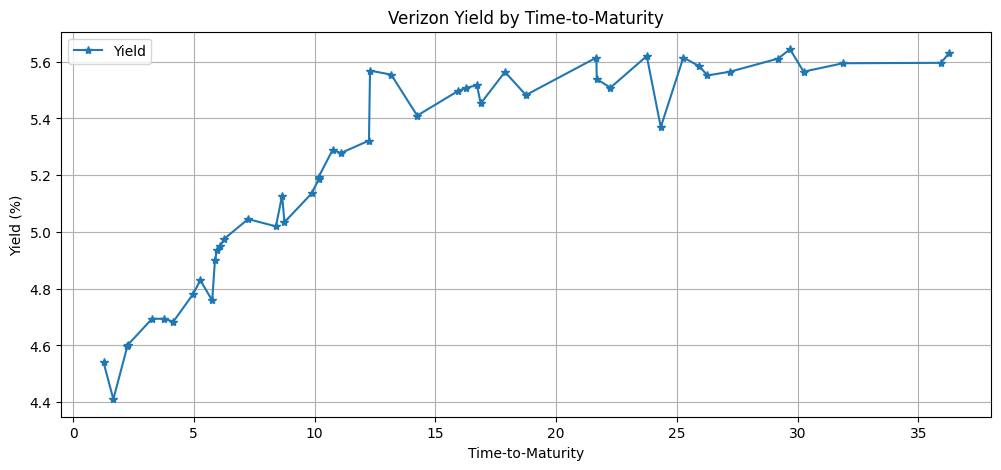

In [48]:
# Bond Symbology Dataframe = Containing both corporate and US Government Bonds
filepath_rawdata = f'./data/bond_symbology.xlsx'
bond_symbology = pd.read_excel(filepath_rawdata)
days_in_year = 365.25
date_today = pd.to_datetime('2024-12-13')
bond_symbology['term'] = ((bond_symbology['maturity']) - bond_symbology['start_date']).dt.days /days_in_year
bond_symbology['TTM'] = ((bond_symbology['maturity'] - date_today)).dt.days /days_in_year
bond_symbology.loc[bond_symbology['TTM'] <= 0, 'TTM'] = 0 # If TTM is less than or equal to 0, then it's 0
# display(bond_symbology.head(3))

# Dataframe of market prices
filepath_rawdata = f'./data/bond_market_prices_eod.xlsx'
data_market = pd.read_excel(filepath_rawdata)
data_market['midPrice'] = (data_market['bidPrice'] + data_market['askPrice'])/2
data_market['midYield'] = (data_market['bidYield'] + data_market['askYield'])/2
# display(data_market.head(3))

# Symbology + Market
df_merged_symbo_market = pd.merge(data_market, bond_symbology, on=['isin', 'class', 'figi', 'ticker'], how='inner')

# Verizon Dataframe with cpn_type == FIXED and amt_out > 100, sorted by maturity
df_vz = df_merged_symbo_market[(df_merged_symbo_market['ticker'] == 'VZ') & 
                               (df_merged_symbo_market['cpn_type'] == 'FIXED') & 
                               (df_merged_symbo_market['amt_out'] > 100)
                               ].sort_values(by = 'maturity')

display(df_vz[['date', 'isin', 'ticker', 'cpn_type', 'amt_out', 'maturity', 'midPrice', 'midYield', 'term', 'TTM']].head())
display(df_vz.head())

plt.figure(figsize=(12, 5))
plt.plot(df_vz['TTM'], df_vz['midYield'], '*-', label='Yield') # X-axis values first, then Y-axis values
plt.title(f'Verizon Yield by Time-to-Maturity')
plt.xlabel('Time-to-Maturity')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid()
plt.show()

## b. Compute bond yields and risk metrics
For each bond, use the bond market mid-price as an input to compute the:

1. bond yields,
2. bond DV01s and
3. bond durations.

You can use section "9. Analytical Duration" in the QuantLib Basics notebook as a template.


In [49]:
# Bond Setup
compounding = ql.Compounded
coupon_freq = ql.Semiannual
day_count = ql.Thirty360(ql.Thirty360.USA)      # For US Corporate bonds use ql.Thirty360(ql.Thirty360.USA)

metrics = []
bond_list = []
df_to_iterate = df_vz

for index, row in df_to_iterate.iterrows():
    bond = create_bond_from_symbology(row)
    
    # Use the midPrice from the dataset
    market_price = row['midPrice']
    
    # Compute implied bond yield directly from market_price (Quantlib Basics Section 7)
    bond_yield = bond.bondYield(market_price, bond.dayCounter(), compounding, coupon_freq)
    bond_yield_rate = ql.InterestRate(bond_yield, day_count, compounding, coupon_freq)

    # Obtain the dirty price from the bond's object
    dirty_price = bond.dirtyPrice(bond_yield, bond.dayCounter(), compounding, coupon_freq)

    bond_duration = ql.BondFunctions.duration(bond, bond_yield_rate)
    bond_convexity = ql.BondFunctions.convexity(bond, bond_yield_rate)
    bond_DV01 = dirty_price * bond_duration / 100

    metrics.append({
        'ticker': row['ticker'],
        'isin': row['isin'],
        'market_price': row['midPrice'],
        'bond_yield': bond_yield * 100, # Show in percent
        'TTM': row['TTM'],
        'bond_duration': bond_duration,
        'bond_DV01': bond_DV01,

    })
    bond_list.append(bond)
    
df_metrics = pd.DataFrame(metrics)
display(df_metrics.head())
display(df_metrics.tail())

,ticker,isin,market_price,bond_yield,TTM,bond_duration,bond_DV01
0,VZ,US92343VGG32,96.2510,4.540637,1.264887,1.222316,1.180725
1,VZ,US92343VDD38,97.1630,4.410096,1.670089,1.589535,1.558465
2,VZ,US92343VDY74,98.9935,4.598220,2.253251,2.102004,2.102524
3,VZ,US92343VFF67,96.5850,4.601817,2.269678,2.142891,2.084712
4,VZ,US92343VGH15,92.2255,4.693826,3.271732,3.081289,2.856832


,ticker,isin,market_price,bond_yield,TTM,bond_duration,bond_DV01
43,VZ,US92343VCM46,90.9420,5.643888,29.686516,14.414326,13.339457
44,VZ,US92343VCZ58,87.0000,5.564662,30.250513,14.876629,13.118357
45,VZ,US92343VFW90,61.4180,5.594471,31.879535,16.812091,10.389817
46,VZ,US92343VFV18,59.9955,5.595825,35.937029,17.428625,10.494153
47,VZ,US92343VGC28,70.2920,5.629801,36.271047,16.486091,11.730733


## c. Calibrate the US Treasury curve
### Calibrate the "on-the-run" US Treasury curveas of 2024-12-13:

... to be used in the hazard rate model calibration.

,date,isin,ticker,midPrice,midYield,term,TTM
0,2024-12-13,US91282CMB45,T,99.37890,4.2225,2.995209,3.003422
1,2024-12-13,US91282CLY56,T,100.00390,4.2470,1.993155,1.963039
2,2024-12-13,US91282CMA61,T,99.44140,4.2510,4.993840,4.963723
3,2024-12-13,US91282CLZ22,T,98.80470,4.3255,6.992471,6.962355
4,2024-12-13,US91282CLW90,T,98.82030,4.3980,9.998631,9.921971
5,2024-12-13,US912810UE63,T,98.34375,4.6020,29.998631,29.921971
6,2024-12-13,US912810UF39,T,99.26565,4.6820,19.953457,19.923340


,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-13,0.000,1.000,4.127
1,2026-11-30,2.000,0.921,4.212
2,2027-12-15,3.000,0.882,4.279
3,2029-11-30,5.000,0.812,4.263
4,2031-11-30,7.000,0.742,4.357
5,2034-11-15,9.917,0.648,4.475
6,2044-11-15,19.917,0.390,4.839
7,2054-11-15,29.917,0.256,4.654


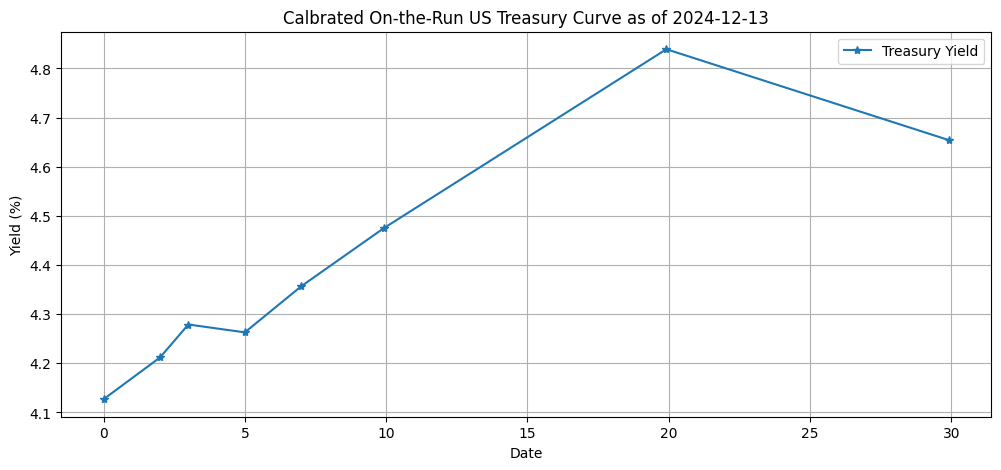

In [50]:
filepath_rawdata = f'./data/govt_on_the_run.xlsx'
df_govt = pd.read_excel(filepath_rawdata)
# r'[BC] Govt$' matches string that ends with B Govt or C Govt
# ~ negates the filter, showing rows that DO NOT match the filter (those that don't have BC)
df_ontherun = df_govt[~df_govt['ticker'].str.contains(r'[BC] Govt$', regex=True)]
# display(df_ontherun.head(3))

# Bond Symbology Dataframe = Containing both corporate and US Government Bonds
filepath_rawdata = f'./data/bond_symbology.xlsx'
bond_symbology = pd.read_excel(filepath_rawdata)
days_in_year = 365.25
date_today = pd.to_datetime('2024-12-13')
bond_symbology['term'] = ((bond_symbology['maturity']) - bond_symbology['start_date']).dt.days /days_in_year
bond_symbology['TTM'] = ((bond_symbology['maturity'] - date_today)).dt.days /days_in_year
bond_symbology.loc[bond_symbology['TTM'] <= 0, 'TTM'] = 0 # If TTM is less than or equal to 0, then it's 0
# display(bond_symbology.head(3))

# Dataframe of market prices
filepath_rawdata = f'./data/bond_market_prices_eod.xlsx'
data_market = pd.read_excel(filepath_rawdata)
data_market['midPrice'] = (data_market['bidPrice'] + data_market['askPrice'])/2
data_market['midYield'] = (data_market['bidYield'] + data_market['askYield'])/2
# display(data_market.head(3))

# Symbology + Market
df_merged_symbo_market = pd.merge(data_market, bond_symbology, on=['isin', 'class', 'figi', 'ticker'], how='inner')

# Symbology + Market + On the Run
govt_combined_otr = pd.merge(df_merged_symbo_market, df_ontherun['isin'], on=['isin'], how='inner')

display(govt_combined_otr[['date', 'isin', 'ticker', 'midPrice', 'midYield', 'term', 'TTM']])

# tsy_yield_curve calibration
govt_combined_otr = govt_combined_otr
tsy_yield_curve = calibrate_yield_curve_from_frame(calc_date, govt_combined_otr, 'midPrice')
tsy_yield_curve_handle = ql.YieldTermStructureHandle(tsy_yield_curve)

tsy_yield_curve_mid_details = get_yield_curve_details_df(tsy_yield_curve, curve_dates=None)
display(tsy_yield_curve_mid_details)

# Input for Scatter Plot
plt.figure(figsize=(12, 5))
plt.plot(tsy_yield_curve_mid_details['YearFrac'], tsy_yield_curve_mid_details['ZeroRate'], '*-', label='Treasury Yield')
plt.title(f'Calbrated On-the-Run US Treasury Curve as of {calc_date.to_date()}')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid()
plt.show()

-----------------------------------------------------------
# Problem 2: Add functions needed to calibrate the Nelson-Siegel (4 parameters) credit model

## a. For a given set of Nelson-Siegel curve shape parameters, write a function to create the corresponding parametric credit curve.
The result should be a DefaultProbabilityTermStructureHandle object, to be used downstream for pricing.

To do: compute nelson_siegel_credit_curve_handle

nelson_siegel_credit_curve_handle = ql.DefaultProbabilityTermStructureHandle(...)

In [51]:
def create_nelson_siegel_curve(calc_date, nelson_siegel_params):
    ''' nelson_siegel_params = (theta1, theta2, theta3, lambda)'''
    
    nelson_siegel_surv_prob_dates = [calc_date + ql.Period(T , ql.Years) for T in range(31)]
    nelson_siegel_surv_prob_dates_pd = [d.to_date() for d in nelson_siegel_surv_prob_dates]
    nelson_siegel_average_hazard_rates = [nelson_siegel(nelson_siegel_params, T) for T in range(31)]
    nelson_siegel_surv_prob_levels = [np.exp(-T * nelson_siegel_average_hazard_rates[T]) for T in range(31)]

    # nelson_siegel_surv_prob_curve
    nelson_siegel_credit_curve = ql.SurvivalProbabilityCurve(nelson_siegel_surv_prob_dates, nelson_siegel_surv_prob_levels, ql.Actual360(), ql.TARGET())
    nelson_siegel_credit_curve.enableExtrapolation()
    nelson_siegel_credit_curve_handle = ql.DefaultProbabilityTermStructureHandle(nelson_siegel_credit_curve)

    return(nelson_siegel_credit_curve_handle)

## b. Write a function to price all bonds in the Nelson-Siegel credit model

Use 40% recovery rate.

Using DefaultProbabilityTermStructureHandle as an input to compute all model prices and yields.

In [52]:
def calculate_nelson_siegel_model_prices_and_yields(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      tsy_yield_curve_handle, 
                      bond_recovery_rate = 0.4):
        
    # Use the create_nelson_siegel_curve function to create nelson_siegel_credit_curve_handle
    nelson_siegel_credit_curve_handle = create_nelson_siegel_curve(calc_date, nelson_siegel_params)

    # nelson_siegel_risky_bond_engine (use tsy_yield_curve_handle)
    nelson_siegel_risky_bond_engine = ql.RiskyBondEngine(nelson_siegel_credit_curve_handle, bond_recovery_rate, tsy_yield_curve_handle)
    fixed_rate_bond_objects.setPricingEngine(nelson_siegel_risky_bond_engine)

    # Price risky bond using Nelson-Siegel survival probability curve
    bond_model_prices = fixed_rate_bond_objects.cleanPrice()
    bond_model_yields = fixed_rate_bond_objects.bondYield(bond_model_prices, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100

    return(bond_model_prices, bond_model_yields)

## c. Write a function to computes the weighted SSE / "Sum of Squared Errors" metric
Write a function to compute the weighted SSE / "Sum of Squared Errors" in price space, defined as sum of squared differences between model and market prices for all Verizon fixed-rate bonds.

Use 1/DV01 as SSE weights, as discussed in Lecture 6. You can ignore the liquidity adjuster for the purpose of this exercise.

In [53]:
def nelson_siegel_sse(nelson_siegel_params, calc_date, fixed_rate_bond_objects, market_prices, 
                      calib_weights, tsy_yield_curve_handle, bond_recovery_rate = 0.4):
    
    # Get model clean prices
    model_prices = []
    for bond in fixed_rate_bond_objects:
        # Grab the model price from the calculate_nelson_siegel_model_prices_and_yields function
        price, _ = calculate_nelson_siegel_model_prices_and_yields(nelson_siegel_params, 
                      calc_date, 
                      bond, # For each bond
                      tsy_yield_curve_handle, 
                      bond_recovery_rate)
        model_prices.append(price)
    
    model_prices = np.array(model_prices)
    
    # Use the market prices given
    market_prices = np.array(market_prices)
    calib_weights = np.array(calib_weights)
    
    # Compute squared price errors
    squared_errors = (model_prices - market_prices) ** 2
    
    # Weighted SSE using 1/DV01    
    sse = np.sum(squared_errors * calib_weights)
    
    return (sse)

## d. Test the functionalty on the initial set of model parameters: 
## initial_nelson_siegel_params = [0.03, -0.01, 0.02, 5.0]

Compute the corresponding initial model prices and yields, as well as initial SSE.

Add following columns to the VZ dataframe and display the head of the results:

| duration | calib_weight | initModelPrice | initModelYield |
|----------|----------|----------|----------|


In [54]:
# Bond Setup
compounding = ql.Compounded
coupon_freq = ql.Semiannual
day_count = ql.Thirty360(ql.Thirty360.USA)      # For US Corporate bonds use ql.Thirty360(ql.Thirty360.USA)
initial_nelson_siegel_params = [0.03, -0.01, 0.02, 5.0]

metrics = []
bond_list = []
df_to_iterate = df_vz

for index, row in df_to_iterate.iterrows():
    bond = create_bond_from_symbology(row)
    
    # Use the midPrice from the dataset
    market_price = row['midPrice']
    
    # Compute implied bond yield directly from bond_market_price (Quantlib Basics Section 7)
    bond_yield = bond.bondYield(market_price, bond.dayCounter(), compounding, coupon_freq)
    bond_yield_rate = ql.InterestRate(bond_yield, day_count, compounding, coupon_freq)

    # Obtain the dirty price from the bond's object
    dirty_price = bond.dirtyPrice(bond_yield, bond.dayCounter(), compounding, coupon_freq)

    bond_duration = ql.BondFunctions.duration(bond, bond_yield_rate)
    bond_convexity = ql.BondFunctions.convexity(bond, bond_yield_rate)
    bond_DV01 = dirty_price * bond_duration / 100

    calib_weights = 1 / bond_DV01
    initModelPrice = calculate_nelson_siegel_model_prices_and_yields(initial_nelson_siegel_params, 
                      calc_date, bond, tsy_yield_curve_handle, bond_recovery_rate = 0.4)[0]
    initModelYield = calculate_nelson_siegel_model_prices_and_yields(initial_nelson_siegel_params, 
                      calc_date, bond, tsy_yield_curve_handle, bond_recovery_rate = 0.4)[1]
    
    metrics.append({
        'ticker': row['ticker'],
        'isin': row['isin'],
        'market_price': row['midPrice'],
        'bond_yield': bond_yield * 100, # Show in percent
        'TTM': row['TTM'],
        'duration': bond_duration,
        'DV01': bond_DV01,
        'calib_weight': calib_weights,
        'initModelPrice': initModelPrice,
        'initModelYield': initModelYield,

    })
    bond_list.append(bond)
    
df_metrics = pd.DataFrame(metrics)
display(df_metrics.head())

# Calculate SSE
sse_value_init = nelson_siegel_sse(
    nelson_siegel_params = initial_nelson_siegel_params,
    calc_date = calc_date,
    fixed_rate_bond_objects = bond_list,
    market_prices = df_metrics['market_price'].values, 
    calib_weights = df_metrics['calib_weight'].values, 
    tsy_yield_curve_handle = tsy_yield_curve_handle, 
    bond_recovery_rate = 0.4)

print(f'Initial SSE: {sse_value_init:.4f}')

,ticker,isin,market_price,bond_yield,TTM,duration,DV01,calib_weight,initModelPrice,initModelYield
0,VZ,US92343VGG32,96.2510,4.540637,1.264887,1.222316,1.180725,0.846937,95.146125,5.483991
1,VZ,US92343VDD38,97.1630,4.410096,1.670089,1.589535,1.558465,0.641657,95.309715,5.614381
2,VZ,US92343VDY74,98.9935,4.598220,2.253251,2.102004,2.102524,0.475619,96.660427,5.724514
3,VZ,US92343VFF67,96.5850,4.601817,2.269678,2.142891,2.084712,0.479683,94.369654,5.679874
4,VZ,US92343VGH15,92.2255,4.693826,3.271732,3.081289,2.856832,0.350038,89.133337,5.798073


Initial SSE: 263.7399


-----------------------------------------------------------
# Problem 3: Calibrate the Nelson-Siegel model
## a. Find the Nelson-Siegel model parameters providing the smooth credit curve which best fits the market.

Use the US "on-the-run" Treasury yield curve for risk-free discounting.

Minimize the SSE (model vs market pricing error) function to obtain the optimal/calibrated Nelson-Siegel parameter vector. 

Create the calibrated/smooth credit curve corresponding to the optimal model parameters.

In [55]:
def calibrate_nelson_siegel_model(initial_nelson_siegel_params,
                                  calc_date, 
                                  bond_details, 
                                  tsy_yield_curve_handle, 
                                  bond_recovery_rate = 0.4):

    # Objective function wrapper
    def objective(params): 
        try:
            return nelson_siegel_sse(
                nelson_siegel_params = params,
                calc_date = calc_date,
                fixed_rate_bond_objects = bond_details,
                market_prices = df_metrics['market_price'].values, 
                calib_weights = df_metrics['calib_weight'].values, 
                tsy_yield_curve_handle = tsy_yield_curve_handle, 
                bond_recovery_rate = bond_recovery_rate
            )
        except:
            return 1e10  # Silent penalty for invalid parameter set
    
    # Parameter bounds (especially important for lambda)
    bounds = [(-0.10, 0.10),   # theta1
              (-0.10, 0.10),   # theta2
              (-0.10, 0.10),   # theta3
              (0.01, 30.0)]    # lambda (must be positive)
    
    # Run optimization
    result = minimize(objective, initial_nelson_siegel_params, method='L-BFGS-B', bounds = bounds)
    
    # calib_results = (theta1, theta2, theta3, lambda)
    calib_results = result.x

    return (calib_results)

initial_nelson_siegel_params = [0.03, -0.01, 0.02, 5.0]
calib_nelson_siegel_params = calibrate_nelson_siegel_model(initial_nelson_siegel_params,
                                  calc_date, 
                                  bond_list, 
                                  tsy_yield_curve_handle, 
                                  bond_recovery_rate = 0.4)
print(calib_nelson_siegel_params)

[ 4.17988370e-02 -3.52061584e-02  1.30397863e-05  2.44101301e+01]


In [56]:
calib_theta1 = calib_nelson_siegel_params[0]
calib_theta2 = calib_nelson_siegel_params[1]
calib_theta3 = calib_nelson_siegel_params[2]
calib_lambda = calib_nelson_siegel_params[3]

print(f"theta1: {calib_theta1:,.6f}")
print(f"theta2: {calib_theta2:,.6f}")
print(f"theta3: {calib_theta3:,.6f}")
print(f"lambda: {calib_lambda:,.6f}")

theta1: 0.041799
theta2: -0.035206
theta3: 0.000013
lambda: 24.410130


## b. Compute smooth model prices, yields and "edges"

Price all Verizon bonds on the calibrated credit curve and compute the corresponding model yields and edges.

Add following columns to the dataframe and display the head of the results:

| modelPrice | modelYield | edgePrice | edgeYield |
|----------|----------|----------|----------|


In [57]:
# Bond Setup
compounding = ql.Compounded
coupon_freq = ql.Semiannual
day_count = ql.Thirty360(ql.Thirty360.USA)      # For US Corporate bonds use ql.Thirty360(ql.Thirty360.USA)
initial_nelson_siegel_params = [0.03, -0.01, 0.02, 5.0]
calib_nelson_siegel_params = calib_nelson_siegel_params

metrics = []
bond_list = []
df_to_iterate = df_vz

for index, row in df_to_iterate.iterrows():
    bond = create_bond_from_symbology(row)
    
    # Use the midPrice from the dataset
    market_price = row['midPrice']
    
    # Compute implied bond yield directly from bond_market_price (Quantlib Basics Section 7)
    bond_yield = bond.bondYield(market_price, bond.dayCounter(), compounding, coupon_freq)
    bond_yield_rate = ql.InterestRate(bond_yield, day_count, compounding, coupon_freq)

    # Obtain the dirty price from the bond's object
    dirty_price = bond.dirtyPrice(bond_yield, bond.dayCounter(), compounding, coupon_freq)

    bond_duration = ql.BondFunctions.duration(bond, bond_yield_rate)
    bond_convexity = ql.BondFunctions.convexity(bond, bond_yield_rate)
    bond_DV01 = dirty_price * bond_duration / 100

    calib_weights = 1 / bond_DV01
    
    # Use initial_nelson_siegel_params
    initModelPrice = calculate_nelson_siegel_model_prices_and_yields(initial_nelson_siegel_params, 
                      calc_date, bond, tsy_yield_curve_handle, bond_recovery_rate = 0.4)[0]
    initModelYield = calculate_nelson_siegel_model_prices_and_yields(initial_nelson_siegel_params, 
                      calc_date, bond, tsy_yield_curve_handle, bond_recovery_rate = 0.4)[1]

    # Use calib_nelson_siegel_params
    ModelPrice = calculate_nelson_siegel_model_prices_and_yields(calib_nelson_siegel_params, 
                      calc_date, bond, tsy_yield_curve_handle, bond_recovery_rate = 0.4)[0]
    ModelYield = calculate_nelson_siegel_model_prices_and_yields(calib_nelson_siegel_params, 
                      calc_date, bond, tsy_yield_curve_handle, bond_recovery_rate = 0.4)[1]
    
    edgePrice = ModelPrice - market_price
    edgeYield = ModelYield - (bond_yield * 100)
    
    metrics.append({
        'ticker': row['ticker'],
        'isin': row['isin'],
        'market_price': row['midPrice'],
        'bond_yield': bond_yield * 100, # Show in percent
        'maturity': row['maturity'],
        'duration': bond_duration,
        'DV01': bond_DV01,
        'calib_weight': calib_weights,
        'initModelPrice': initModelPrice,
        'initModelYield': initModelYield,
        'ModelPrice': ModelPrice,
        'ModelYield': ModelYield,
        'edgePrice': edgePrice,
        'edgeYield': edgeYield,

    })
    bond_list.append(bond)
    
df_metrics = pd.DataFrame(metrics)
display(df_metrics.head())

sse_value_final = nelson_siegel_sse(
    nelson_siegel_params = calib_nelson_siegel_params,
    calc_date = calc_date,
    fixed_rate_bond_objects = bond_list,
    market_prices = df_metrics['market_price'].values, 
    calib_weights = df_metrics['calib_weight'].values, 
    tsy_yield_curve_handle = tsy_yield_curve_handle, 
    bond_recovery_rate = 0.4)

print(f'Final SSE: {sse_value_final:.4f}')

,ticker,isin,market_price,bond_yield,maturity,duration,DV01,calib_weight,initModelPrice,initModelYield,ModelPrice,ModelYield,edgePrice,edgeYield
0,VZ,US92343VGG32,96.2510,4.540637,2026-03-20,1.222316,1.180725,0.846937,95.146125,5.483991,96.280431,4.515716,0.029431,-0.024921
1,VZ,US92343VDD38,97.1630,4.410096,2026-08-15,1.589535,1.558465,0.641657,95.309715,5.614381,96.853087,4.609372,-0.309913,0.199276
2,VZ,US92343VDY74,98.9935,4.598220,2027-03-16,2.102004,2.102524,0.475619,96.660427,5.724514,98.827009,4.677490,-0.166491,0.079270
3,VZ,US92343VFF67,96.5850,4.601817,2027-03-22,2.142891,2.084712,0.479683,94.369654,5.679874,96.500846,4.642207,-0.084154,0.040390
4,VZ,US92343VGH15,92.2255,4.693826,2028-03-22,3.081289,2.856832,0.350038,89.133337,5.798073,92.115526,4.732347,-0.109974,0.038521


Final SSE: 3.7108


The Final SSE is significantly lower.

-----------------------------------------------------------
# Problem 4: Visualize the results of the credit model calibration

## a. Plot the model vs market prices (Y-axis) by maturity (X-axis).

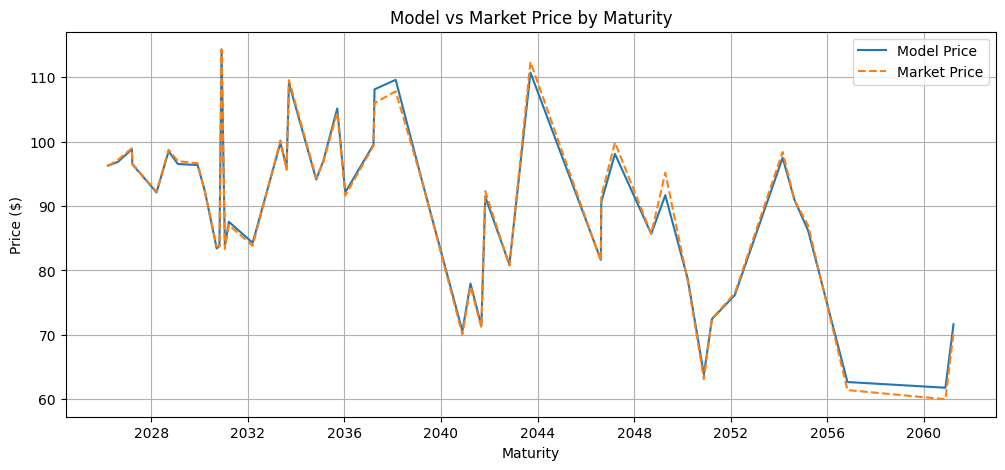

In [58]:
plt.figure(figsize=(12, 5))
# X-axis values first, then Y-axis values
plt.plot(df_metrics['maturity'], df_metrics['ModelPrice'], '-', label='Model Price') 
plt.plot(df_metrics['maturity'], df_metrics['market_price'], '--', label='Market Price') 
plt.title(f'Model vs Market Price by Maturity')
plt.xlabel('Maturity')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()
plt.show()

## b. Plot the model vs market yields (Y-axis) by maturity (X-axis).

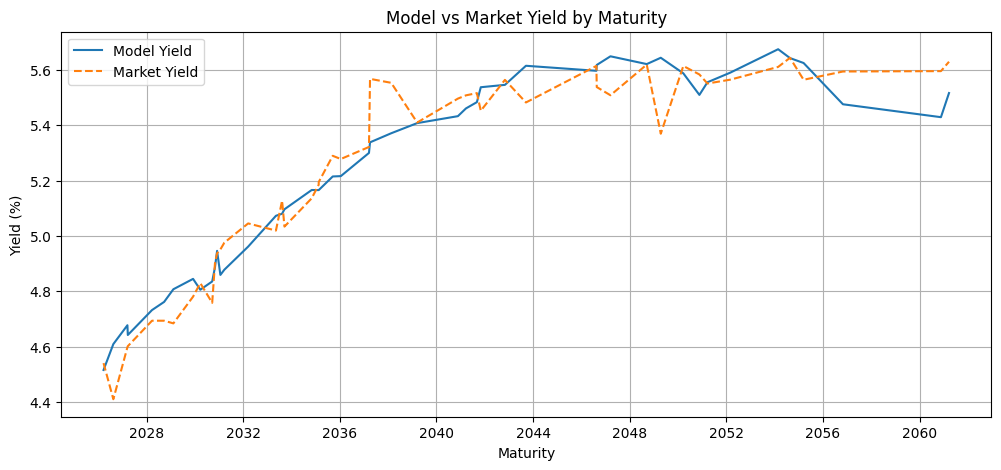

In [59]:
plt.figure(figsize=(12, 5))
# X-axis values first, then Y-axis values
plt.plot(df_metrics['maturity'], df_metrics['ModelYield'], '-', label='Model Yield') 
plt.plot(df_metrics['maturity'], df_metrics['bond_yield'], '--', label='Market Yield') 
plt.title(f'Model vs Market Yield by Maturity')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid()
plt.show()

## c. Plot the edges in yield space (Y-axis) by maturity (X-axis).

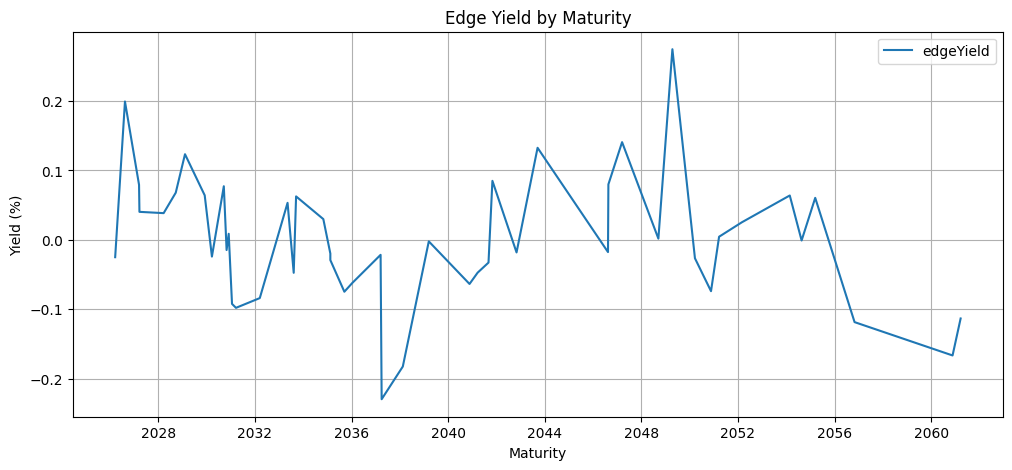

In [60]:
plt.figure(figsize=(12, 5))
# X-axis values first, then Y-axis values
plt.plot(df_metrics['maturity'], df_metrics['edgeYield'], '-', label='edgeYield') 
plt.title(f'Edge Yield by Maturity')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid()
plt.show()

## d. What do you think about the quality of the model fit?

The model fit is very high. We can see that the edge yields are only between -0.2% and 0.3%. The calibrated model yields and prices also fit the market yields and prices; we can see it from the graphs in a) and b). 

The SSE of the final calibrated Nelson-Siegel Model is also very low, 3.7108.

The quality of the model fit is very good. 